This notebook is seeing what happens when we only use the particle $p_T$ information in the ground space (i.e. make this a 1D only problem).

# Information about data

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for doing some preliminary exploration!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022),
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [ ]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

# Google Drive preliminaries (since we're running on Google Colab)

In [ ]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [ ]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)).

In [ ]:
!pip install POT

In [ ]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
import ot
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

# Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [ ]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge


# Load data

For more details on the data structure, see [this exploratory notebook](https://colab.research.google.com/drive/138CL8n4gCtramqaaI-i0EUZ7n4f1SWVh?usp=sharing).

In [ ]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

# Balanced 1D OT calculation with zero-padding; $m_i=1/19$

We'll be using the 2-Wasserstein distance squared as our anomaly score. We assume the ground space is 1 dimensional $(p_T)$.

       OTSCHEME:  Determines what scheme will be used to calculate the OT distance.
                  Note the exact meaning varies somewhat depending on the choice of COSTSCHEME.
                  It's a dictionary of 3 booleans cooresponding to whether the PT is normalized,
                  whether the OT calculation is balanced, and whether the zero padding should be
                  removed. Namely,
                  OTSCHEME['normPT']      ==True:  Means that the pT should be normalized;
                                         ==False:  Means that the pT should be unnormalized
                  OTSCHEME['balanced']    ==True:  Means that the OT calculation should be balanced;
                                         ==False:  Means that the OT calculation should be unbalanced
                  OTSCHEME['noZeroPad']   ==True:  Means that the zero padding should be removed;
                                         ==False:  Means that the zero padding should be kept
                  OTSCHEME['individualOT']==True:  Means that the OT calculation is done on each species separately;
                                         ==False:  Means that the OT calculation is done ignoring species type    
     COSTSCHEME:  Determines what scheme will be used to calculate the ground cost matrix. Options are:
                  - 1DpT: Ground space is pT only
                  - 2D:   Ground space is 2D (eta,phi); note mass is pT
                  - 3D:   Ground space is 3D (pT,eta,phi); note mass is uniform

In [ ]:
OTSCHEME = {}
OTSCHEME['normPT']       = False # pT should be unnormalized per event
OTSCHEME['balanced']     = True  # OT calculation is balanced
OTSCHEME['noZeroPad']    = False # zero padding is kept
OTSCHEME['individualOT'] = False # Don't calculate individual species OT
COSTSCHEME            = '1DpT'   # pT ground space
kwargs                = {}    # No other arguments to set

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

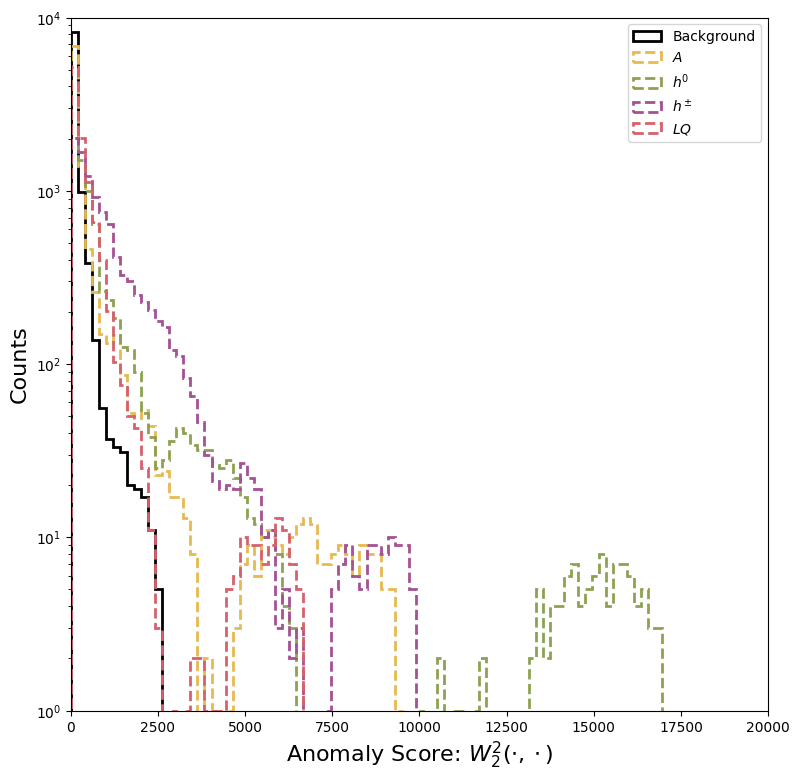

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 20000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

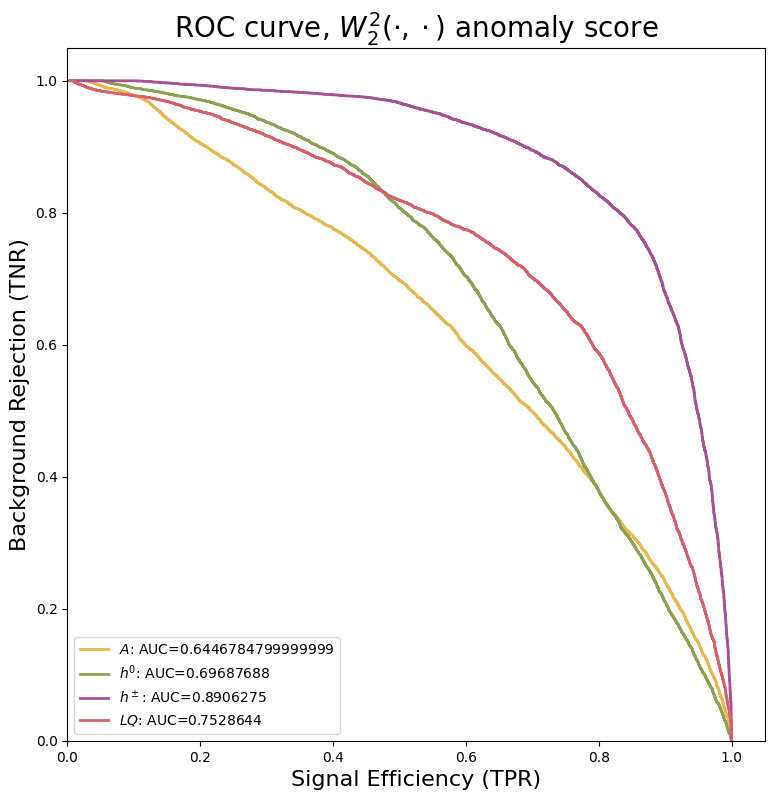

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

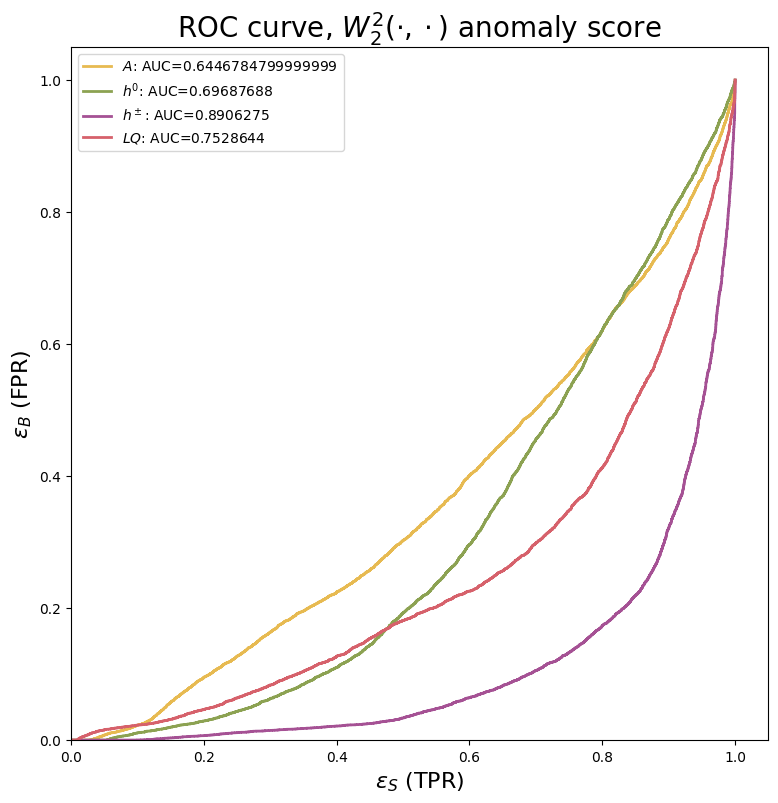

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

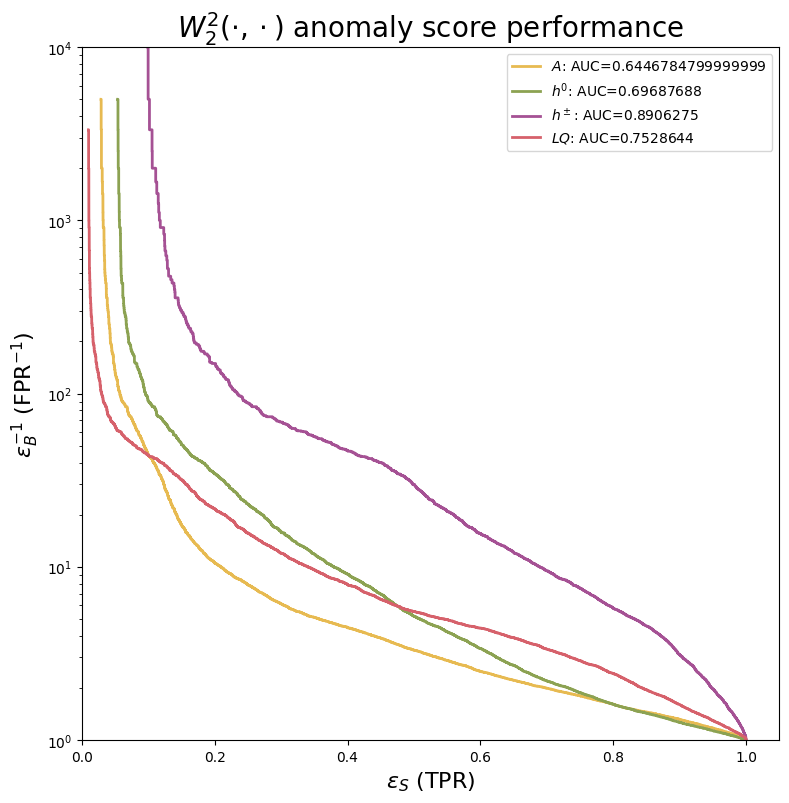

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

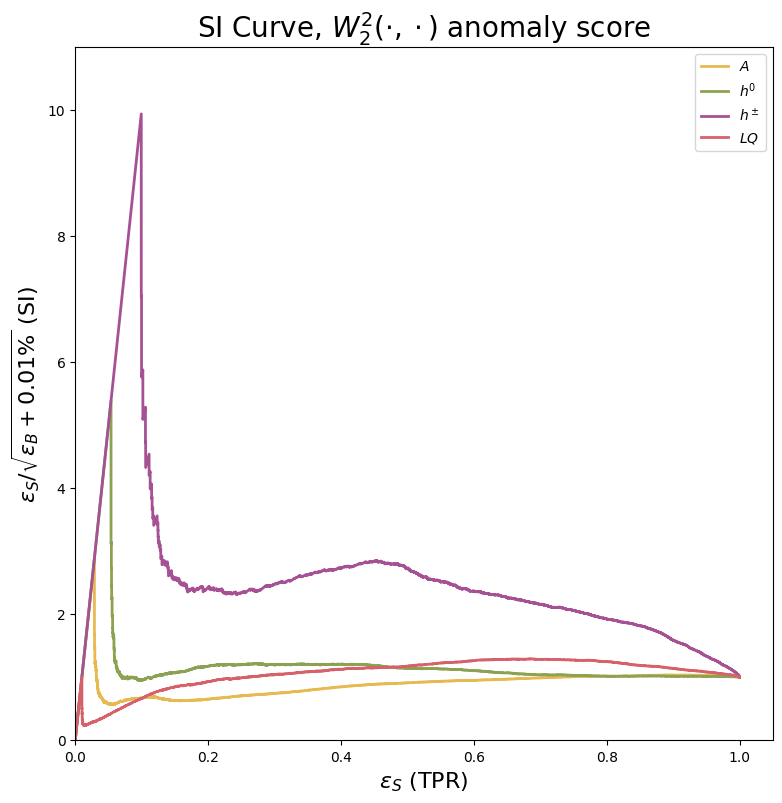

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 11)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0994 0.0994 0.0998]
[0.         0.01       9.94       7.0286414  7.05692568]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.6446784799999999
     $h^0$: 0.69687688
   $h^\pm$: 0.8906275
      $LQ$: 0.7528644


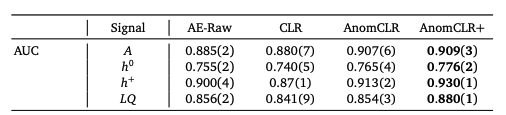

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2024, 1024, 282, 1288]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 6.127450980392156 (TPR=0.3)
     $h^0$: 15.948963317384369 (TPR=0.3)
   $h^\pm$: 68.9655172413793 (TPR=0.2982)
      $LQ$: 12.004801920768308 (TPR=0.2997)


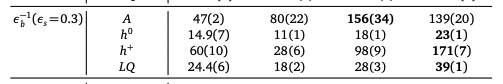

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.7423832462159247 (TPR=0.3)
     $h^0$: 1.1971303267014333 (TPR=0.3)
   $h^\pm$: 2.4679207598122614 (TPR=0.2982)
      $LQ$: 1.037776226555069 (TPR=0.2997)


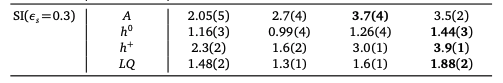

# Balanced 1D OT calculation without zero-padding; $m_i = 1/N$

We'll be using the 2-Wasserstein distance squared as our anomaly score. We assume the ground space is 1 dimensional $(p_T)$.

       OTSCHEME:  Determines what scheme will be used to calculate the OT distance.
                  Note the exact meaning varies somewhat depending on the choice of COSTSCHEME.
                  It's a dictionary of 3 booleans cooresponding to whether the PT is normalized,
                  whether the OT calculation is balanced, and whether the zero padding should be
                  removed. Namely,
                  OTSCHEME['normPT']      ==True:  Means that the pT should be normalized;
                                         ==False:  Means that the pT should be unnormalized
                  OTSCHEME['balanced']    ==True:  Means that the OT calculation should be balanced;
                                         ==False:  Means that the OT calculation should be unbalanced
                  OTSCHEME['noZeroPad']   ==True:  Means that the zero padding should be removed;
                                         ==False:  Means that the zero padding should be kept
                  OTSCHEME['individualOT']==True:  Means that the OT calculation is done on each species separately;
                                         ==False:  Means that the OT calculation is done ignoring species type    
     COSTSCHEME:  Determines what scheme will be used to calculate the ground cost matrix. Options are:
                  - 1DpT: Ground space is pT only
                  - 2D:   Ground space is 2D (eta,phi); note mass is pT
                  - 3D:   Ground space is 3D (pT,eta,phi); note mass is uniform

In [ ]:
OTSCHEME = {}
OTSCHEME['normPT']       = False # pT should be unnormalized per event
OTSCHEME['balanced']     = True # OT calculation is balanced
OTSCHEME['noZeroPad']    = True  # zero padding is removed
OTSCHEME['individualOT'] = False # Don't calculate individual species OT
COSTSCHEME            = '1DpT'   # pT ground space
kwargs                = {}    # No other arguments to set

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

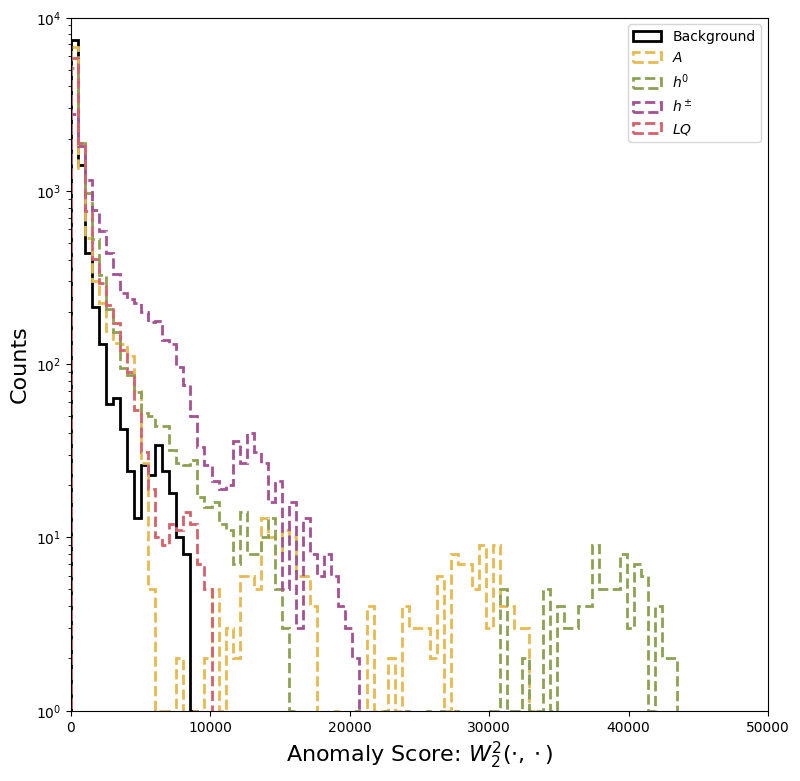

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 50000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

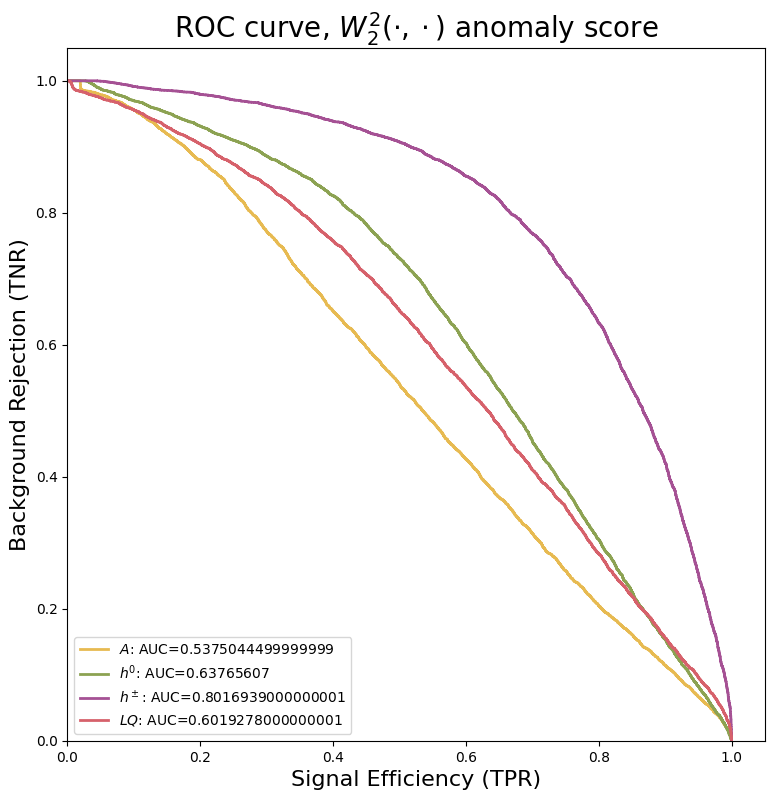

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

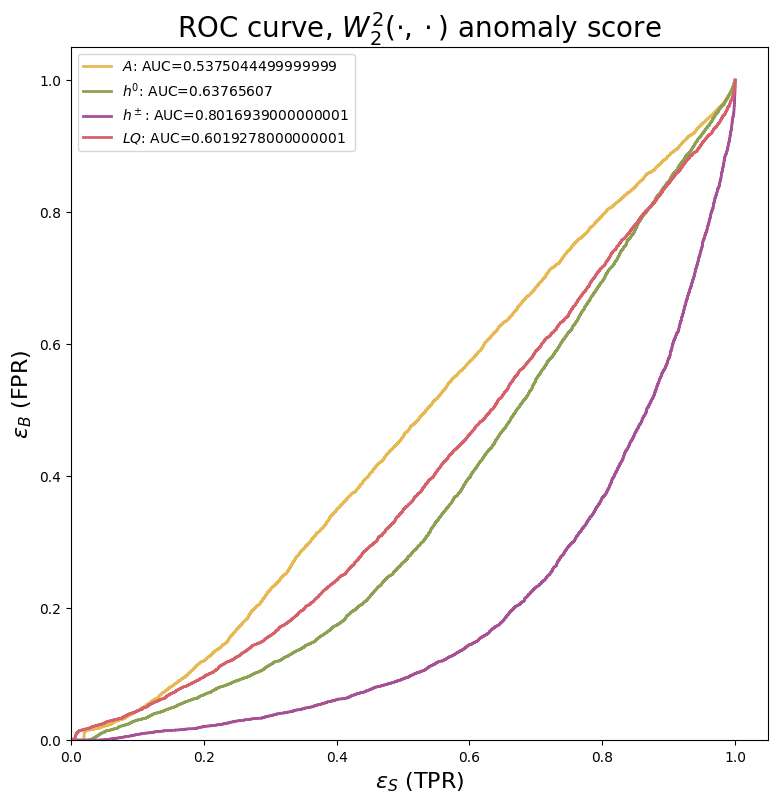

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

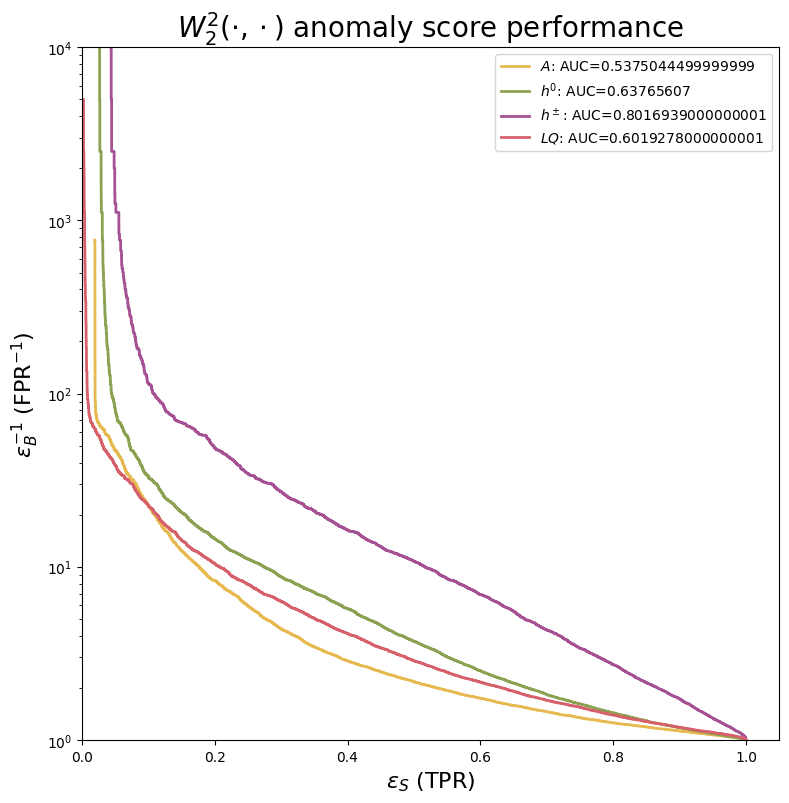

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

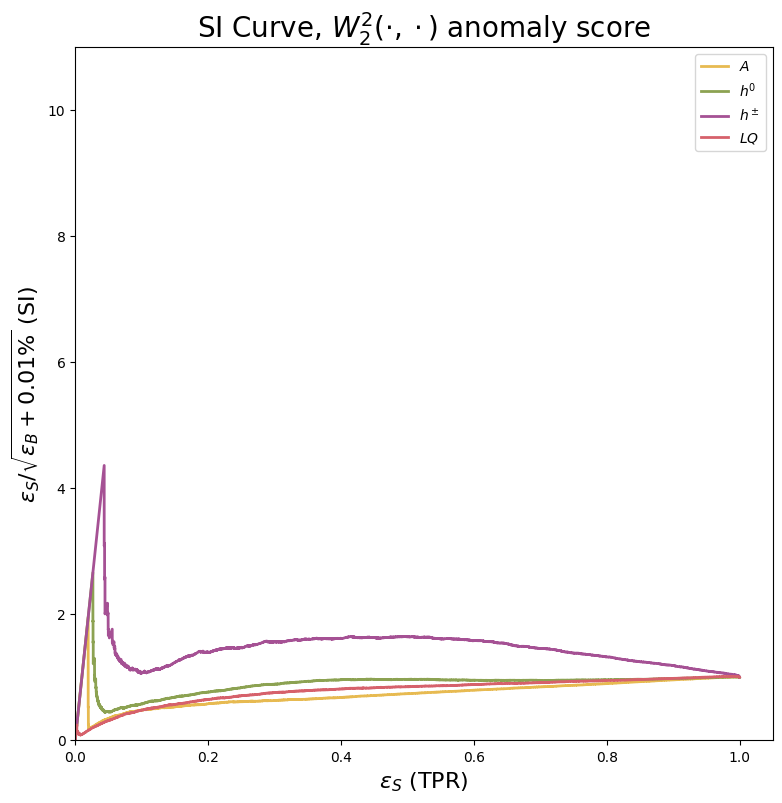

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 11)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0436 0.0436 0.0442]
[0.         0.01       4.36       3.08298557 3.12541197]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.5375044499999999
     $h^0$: 0.63765607
   $h^\pm$: 0.8016939000000001
      $LQ$: 0.6019278000000001


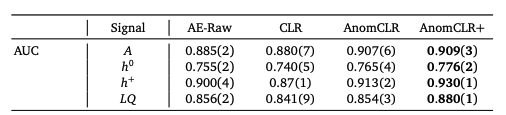

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2322, 1594, 628, 1958]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 4.389815627743634 (TPR=0.2999)
     $h^0$: 8.779631255487269 (TPR=0.3)
   $h^\pm$: 27.17391304347826 (TPR=0.3007)
      $LQ$: 6.3411540900443875 (TPR=0.3001)


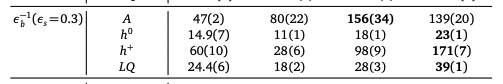

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.6282092157714393 (TPR=0.2999)
     $h^0$: 0.8885233166386385 (TPR=0.3)
   $h^\pm$: 1.5653816733301282 (TPR=0.3007)
      $LQ$: 0.755461777214064 (TPR=0.3001)


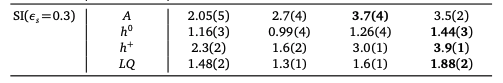

# Unbalanced 1D OT calculation; $m_i = 1$

We'll be using the 2-Wasserstein distance squared as our anomaly score. We assume the ground space is 1 dimensional $(p_T)$.

       OTSCHEME:  Determines what scheme will be used to calculate the OT distance.
                  Note the exact meaning varies somewhat depending on the choice of COSTSCHEME.
                  It's a dictionary of 3 booleans cooresponding to whether the PT is normalized,
                  whether the OT calculation is balanced, and whether the zero padding should be
                  removed. Namely,
                  OTSCHEME['normPT']      ==True:  Means that the pT should be normalized;
                                         ==False:  Means that the pT should be unnormalized
                  OTSCHEME['balanced']    ==True:  Means that the OT calculation should be balanced;
                                         ==False:  Means that the OT calculation should be unbalanced
                  OTSCHEME['noZeroPad']   ==True:  Means that the zero padding should be removed;
                                         ==False:  Means that the zero padding should be kept
                  OTSCHEME['individualOT']==True:  Means that the OT calculation is done on each species separately;
                                         ==False:  Means that the OT calculation is done ignoring species type    
     COSTSCHEME:  Determines what scheme will be used to calculate the ground cost matrix. Options are:
                  - 1DpT: Ground space is pT only
                  - 2D:   Ground space is 2D (eta,phi); note mass is pT
                  - 3D:   Ground space is 3D (pT,eta,phi); note mass is uniform

In [ ]:
OTSCHEME = {}
OTSCHEME['normPT']       = False # pT should be unnormalized per event
OTSCHEME['balanced']     = False # OT calculation is unbalanced
OTSCHEME['noZeroPad']    = True  # zero padding is removed
OTSCHEME['individualOT'] = False # Don't calculate individual species OT
COSTSCHEME            = '1DpT'   # pT ground space

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

## div=L2; $\kappa=10$

In [ ]:
kwargs          = {}
kwargs['div']   = 'l2'
kwargs['reg_m'] = 10.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about ??s of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

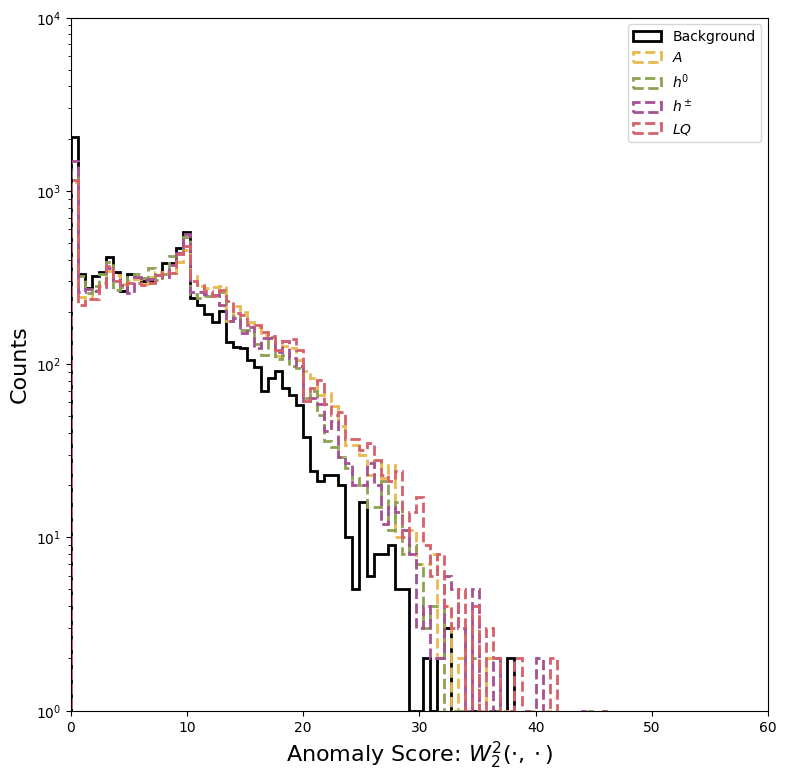

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 60)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

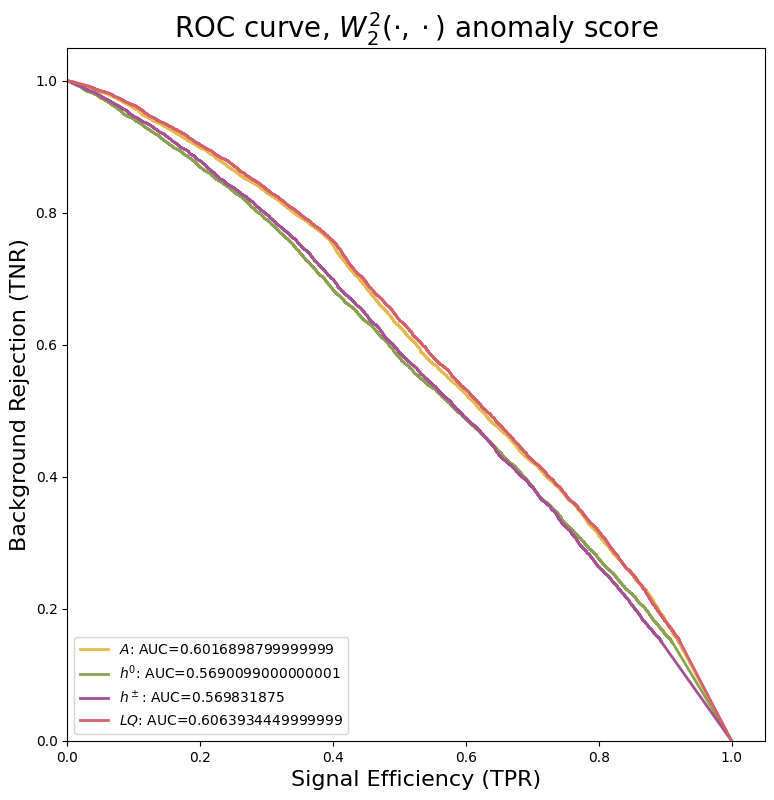

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

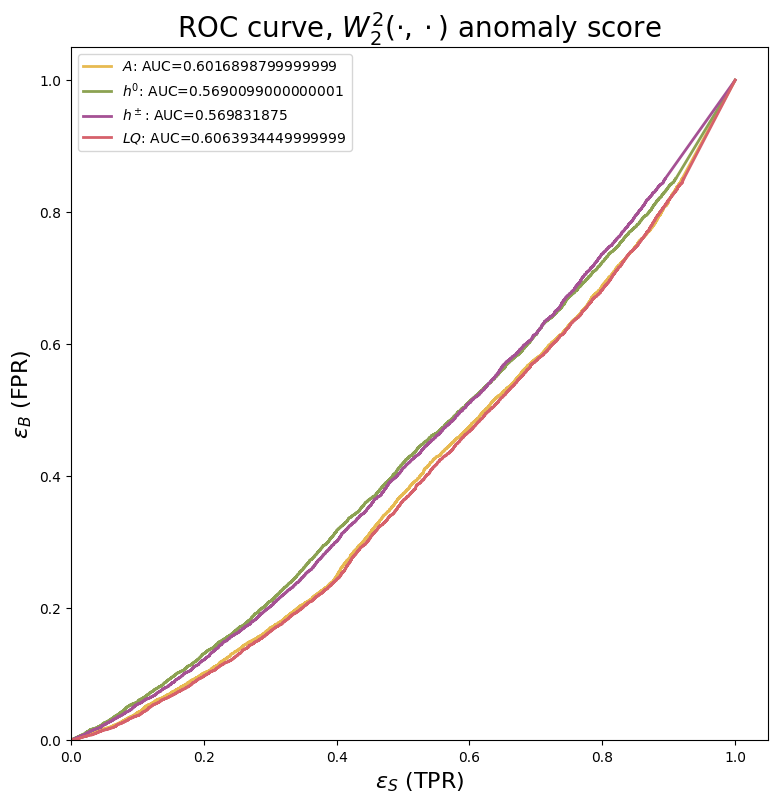

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

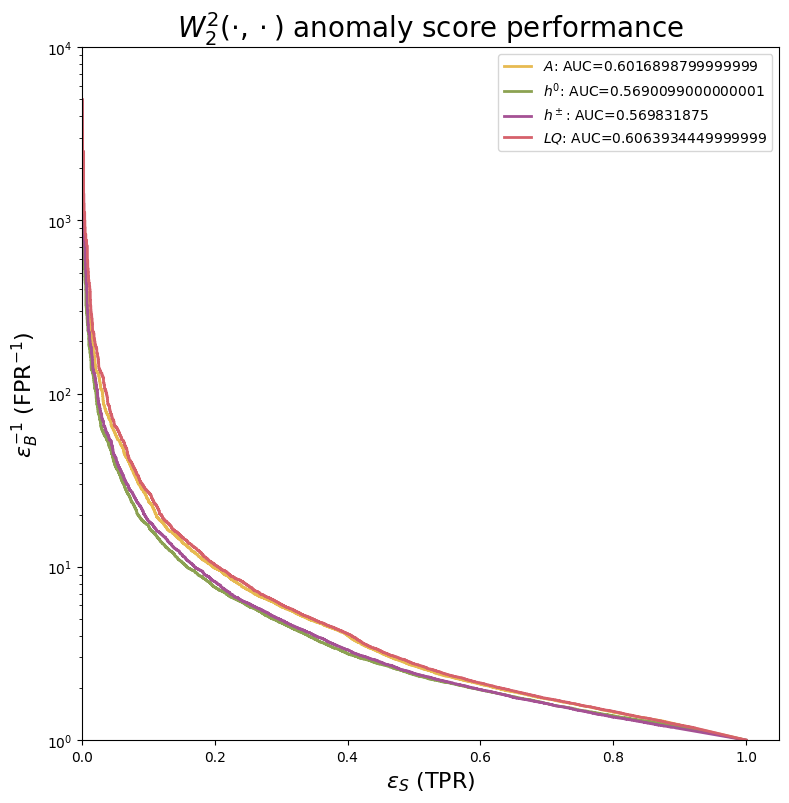

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

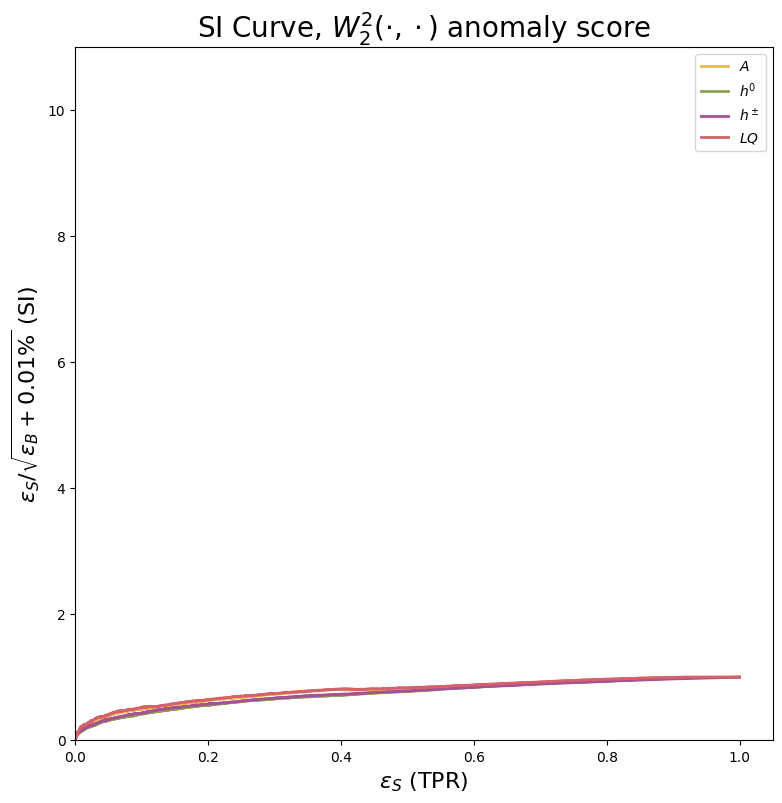

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 11)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0005 0.0005 0.0007]
[0.         0.01       0.05       0.02886751 0.04041452]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.6016898799999999
     $h^0$: 0.5690099000000001
   $h^\pm$: 0.569831875
      $LQ$: 0.6063934449999999


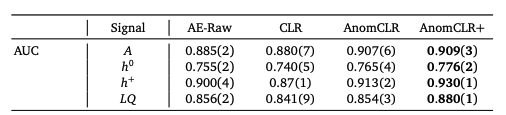

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2142, 2462, 2412, 2102]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 5.899705014749262 (TPR=0.3)
     $h^0$: 4.75963826749167 (TPR=0.2997)
   $h^\pm$: 4.948045522018803 (TPR=0.3001)
      $LQ$: 6.086427267194157 (TPR=0.3001)


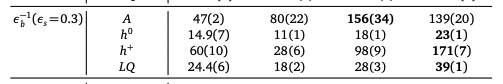

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.7284643967679482 (TPR=0.3)
     $h^0$: 0.6536878112061638 (TPR=0.2997)
   $h^\pm$: 0.667383430216689 (TPR=0.3001)
      $LQ$: 0.7401420673123187 (TPR=0.3001)


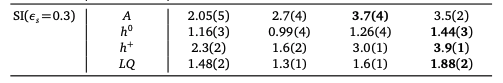

## div=L2; $\kappa=20$

In [ ]:
kwargs          = {}
kwargs['div']   = 'l2'
kwargs['reg_m'] = 20.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about ??s of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

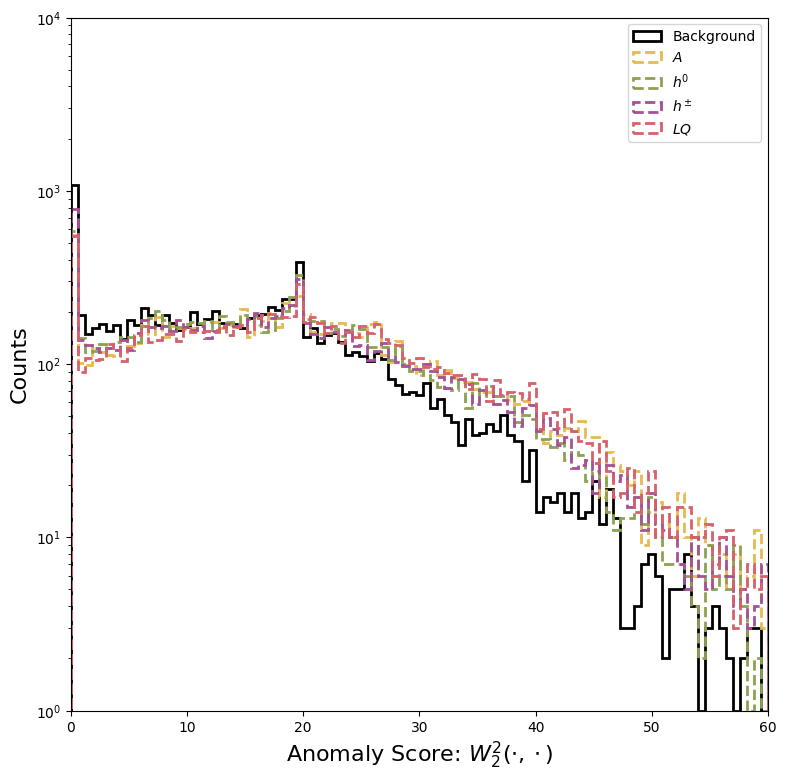

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 60)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

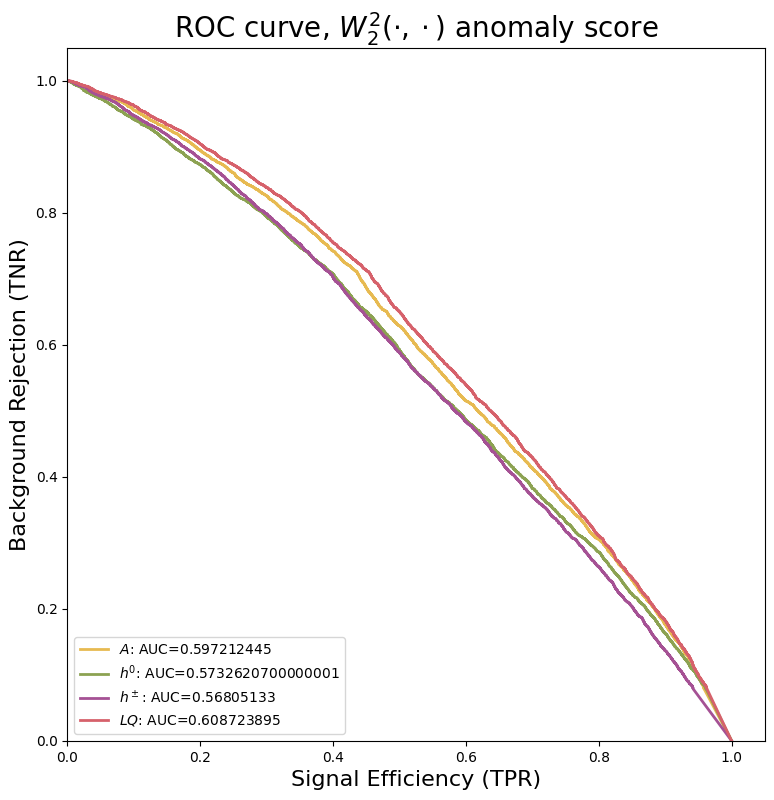

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

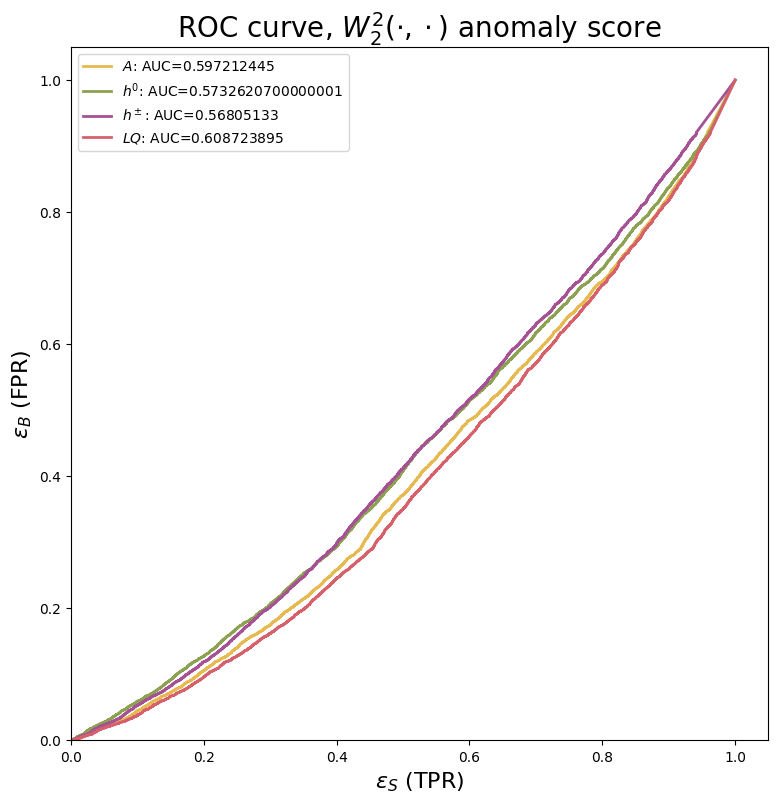

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

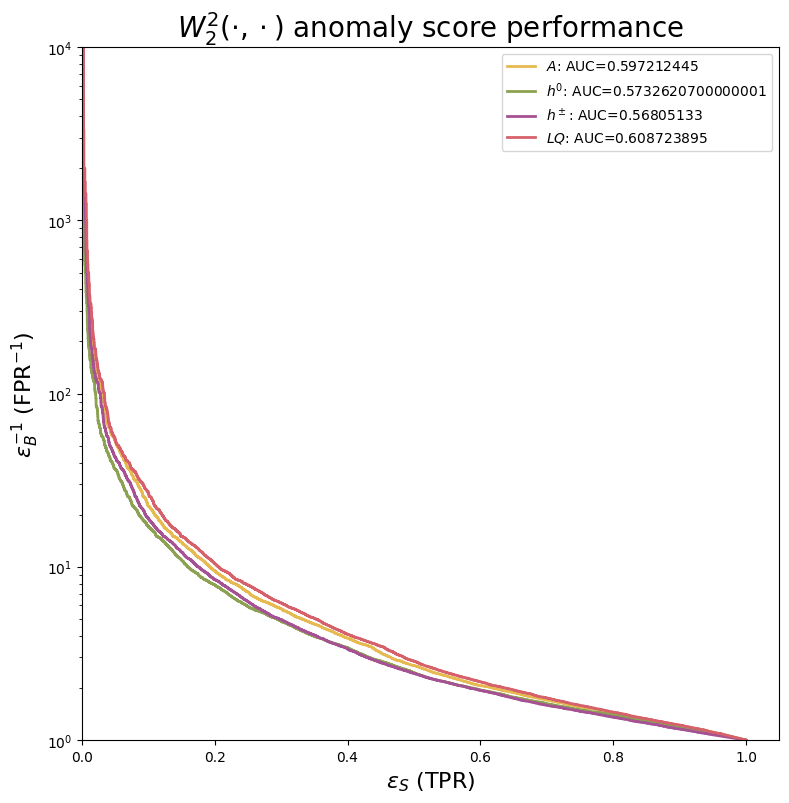

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

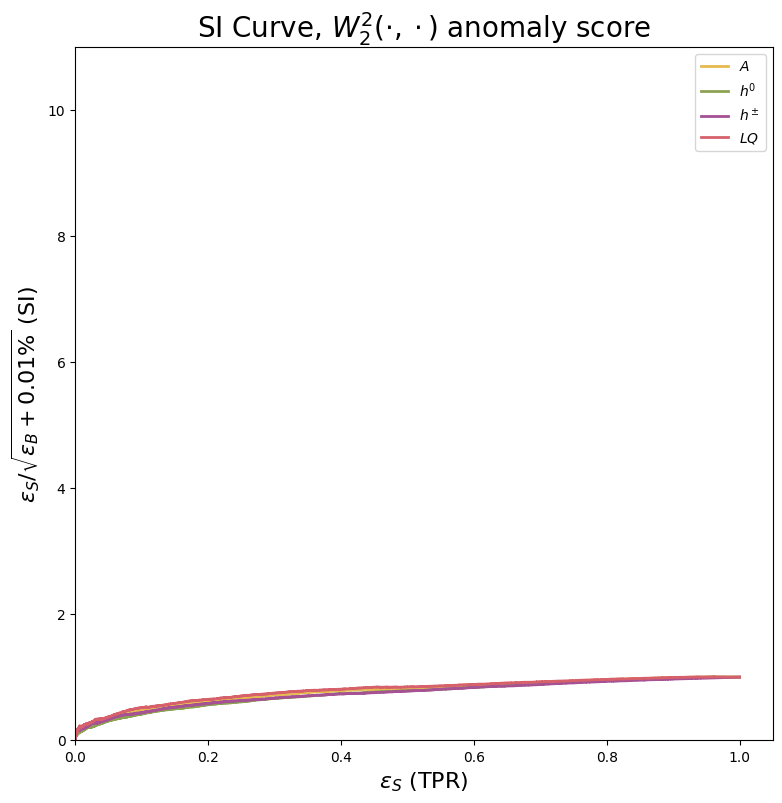

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 11)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0009 0.0009 0.0024]
[0.         0.01       0.09       0.06363961 0.16970563]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.597212445
     $h^0$: 0.5732620700000001
   $h^\pm$: 0.56805133
      $LQ$: 0.608723895


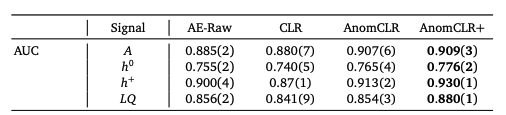

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2182, 2424, 2414, 2000]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 5.7405281285878305 (TPR=0.3)
     $h^0$: 4.863813229571984 (TPR=0.2999)
   $h^\pm$: 4.970178926441352 (TPR=0.3002)
      $LQ$: 6.188118811881188 (TPR=0.3)


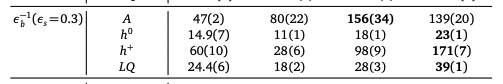

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.7185757571479554 (TPR=0.3)
     $h^0$: 0.6612403086217842 (TPR=0.2999)
   $h^\pm$: 0.6690965652366818 (TPR=0.3002)
      $LQ$: 0.7460470969529908 (TPR=0.3)


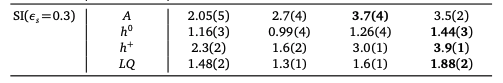

## div=L2; $\kappa=100$

In [ ]:
kwargs          = {}
kwargs['div']   = 'l2'
kwargs['reg_m'] = 100.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about ??s of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

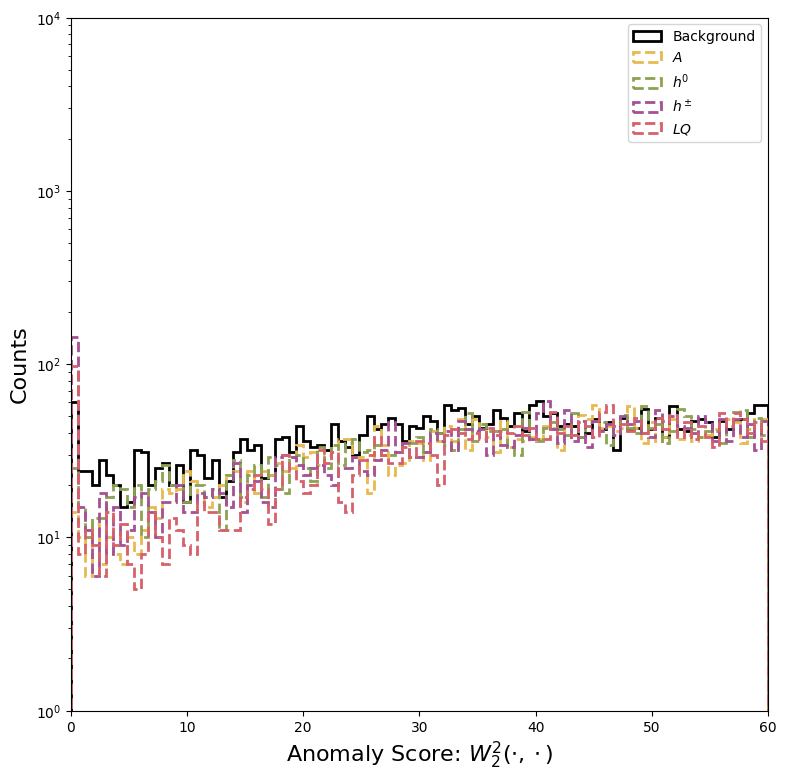

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 60)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

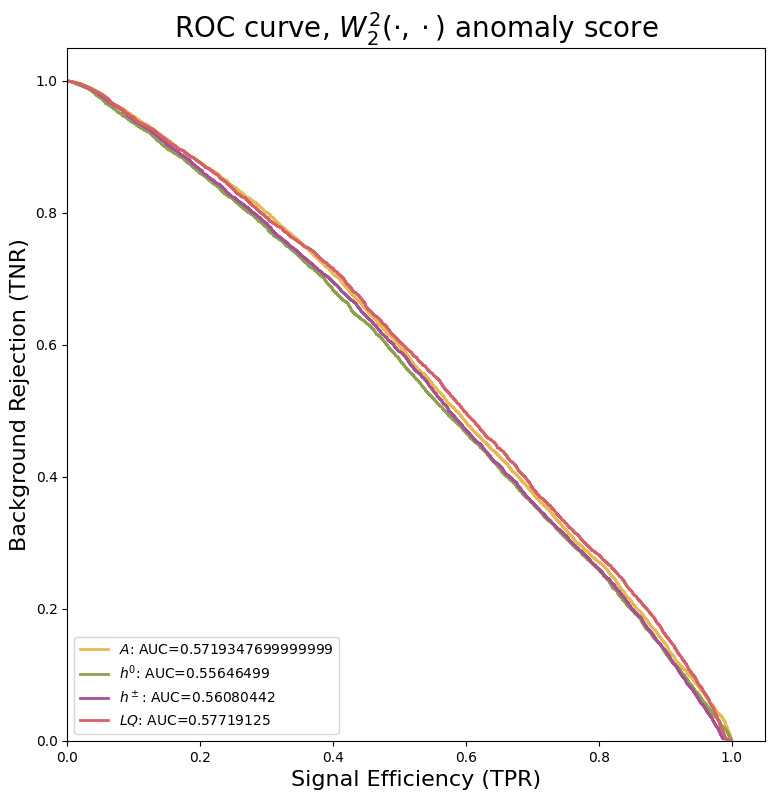

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

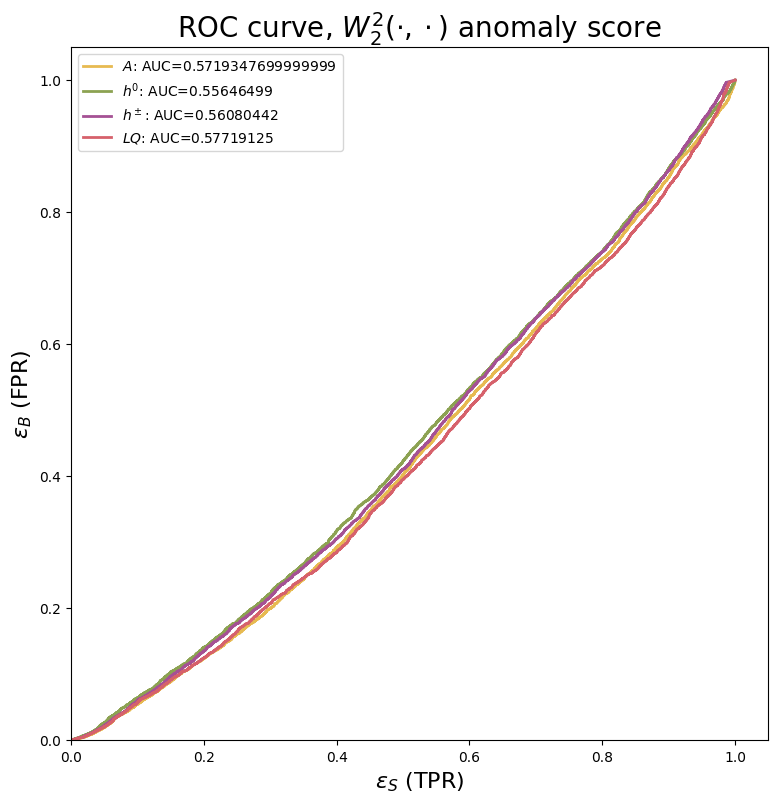

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

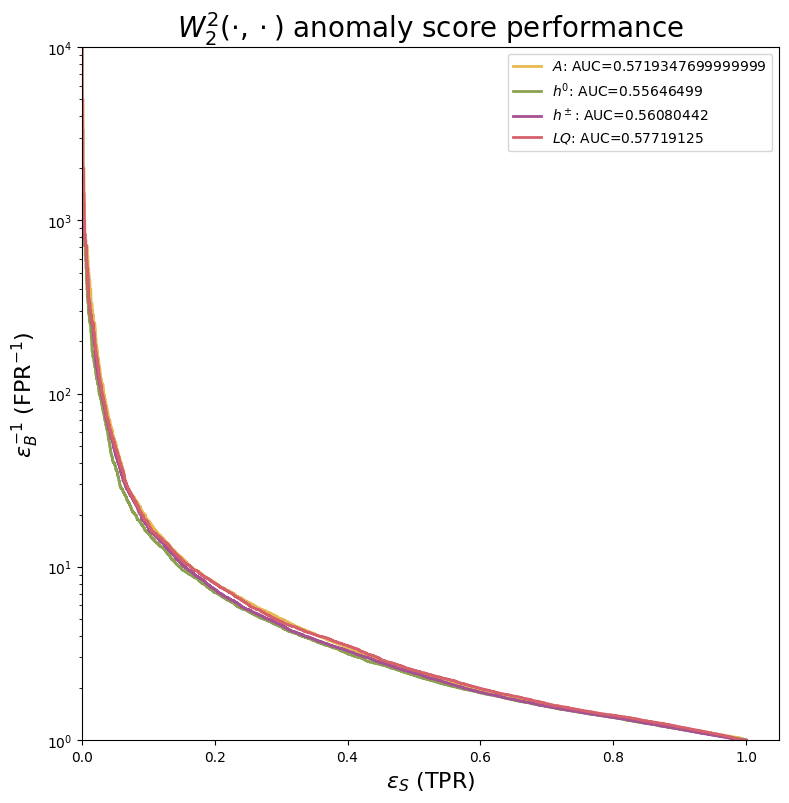

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

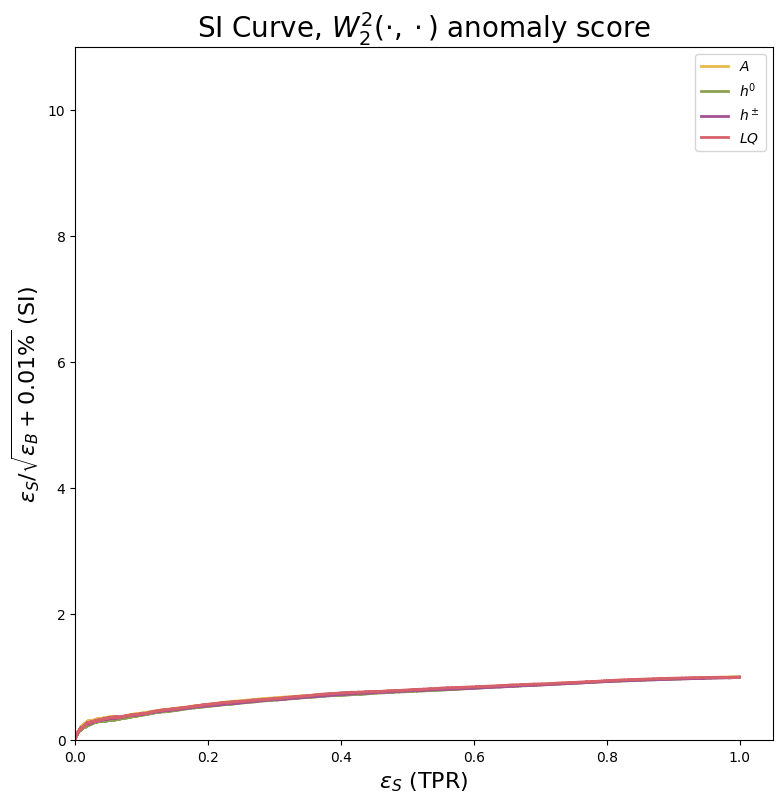

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 11)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0002 0.0002 0.0003]
[0.         0.01       0.02       0.01414214 0.0212132 ]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.5719347699999999
     $h^0$: 0.55646499
   $h^\pm$: 0.56080442
      $LQ$: 0.57719125


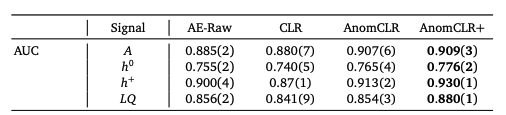

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2418, 2524, 2484, 2421]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 5.022601707684581 (TPR=0.2999)
     $h^0$: 4.510599909788001 (TPR=0.3002)
   $h^\pm$: 4.623208506703652 (TPR=0.3)
      $LQ$: 4.830917874396135 (TPR=0.3)


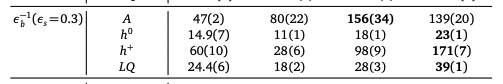

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.6719420170648571 (TPR=0.2999)
     $h^0$: 0.6374262099482143 (TPR=0.3002)
   $h^\pm$: 0.6449003705885217 (TPR=0.3)
      $LQ$: 0.6592212604335734 (TPR=0.3)


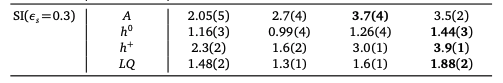

## div=KL; $\kappa=10$

In [ ]:
kwargs          = {}
kwargs['div']   = 'kl'
kwargs['reg_m'] = 10.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about ??s of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

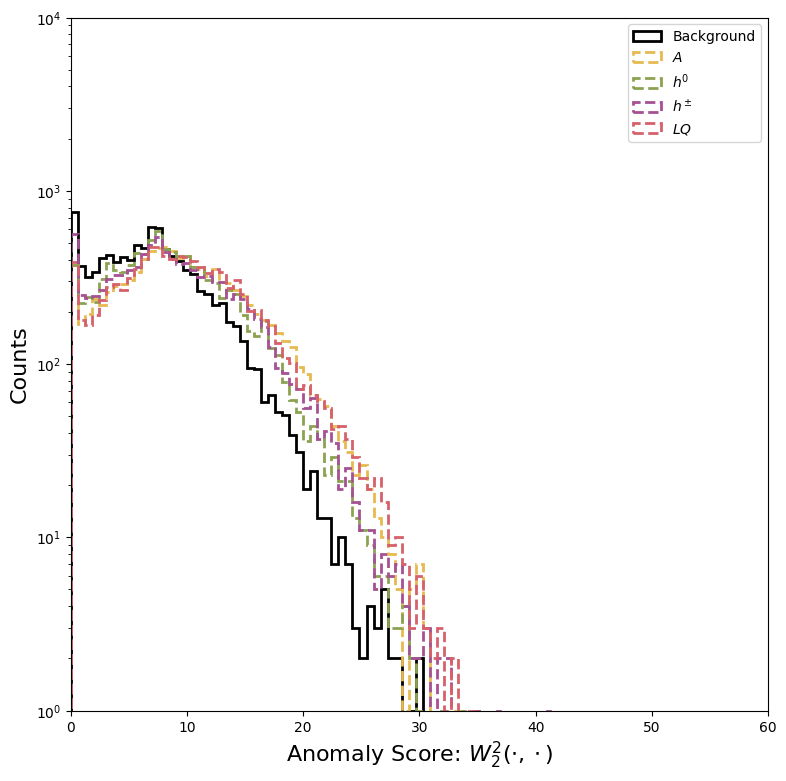

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 60)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

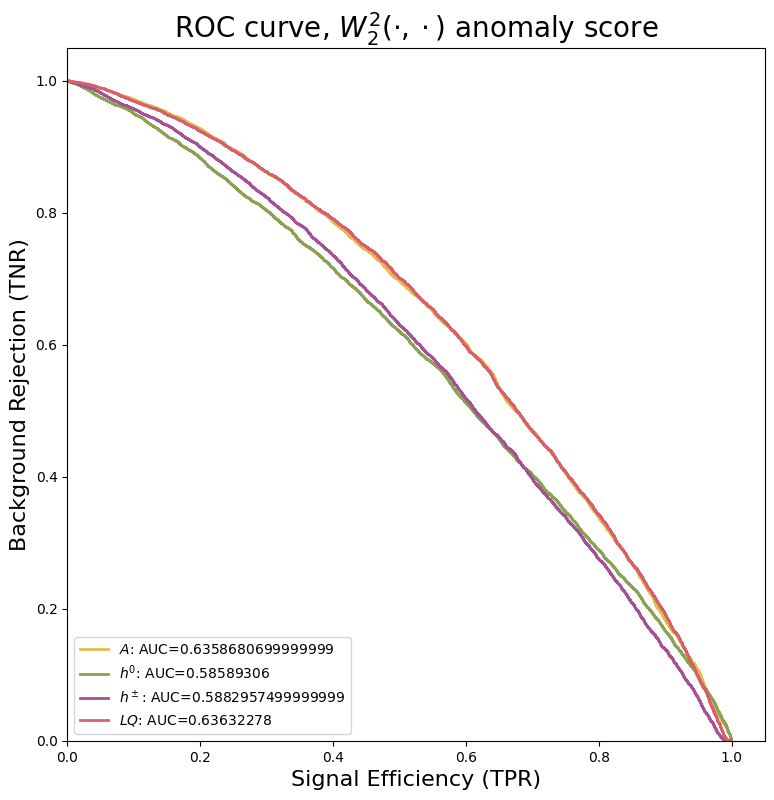

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

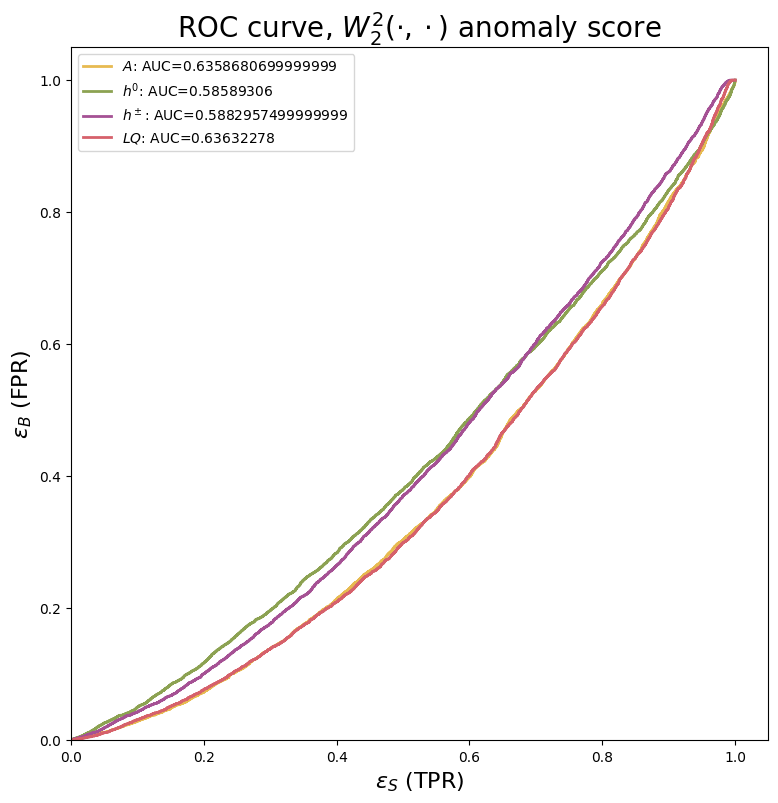

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

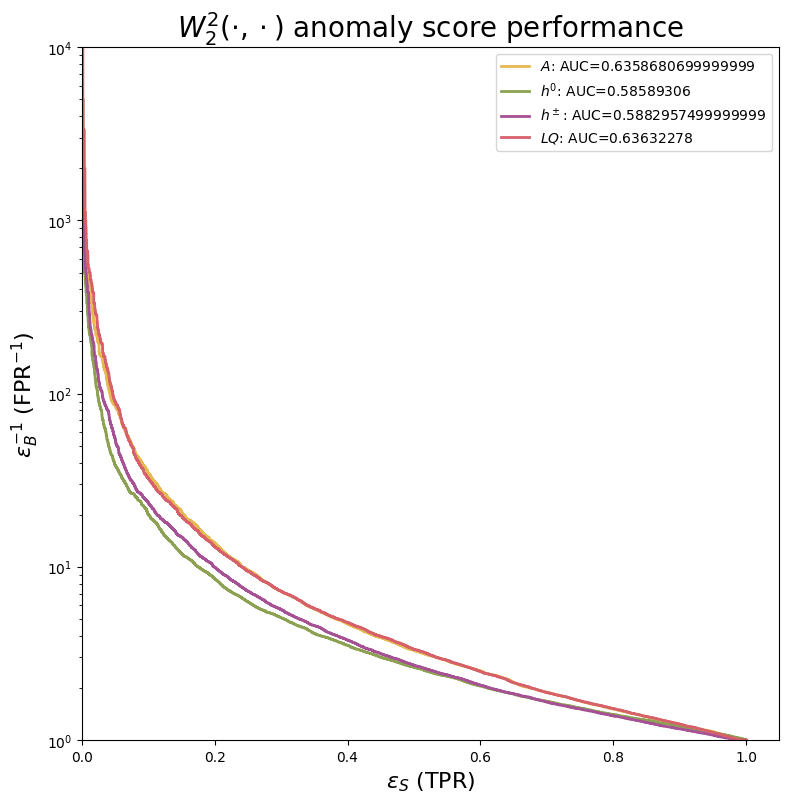

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

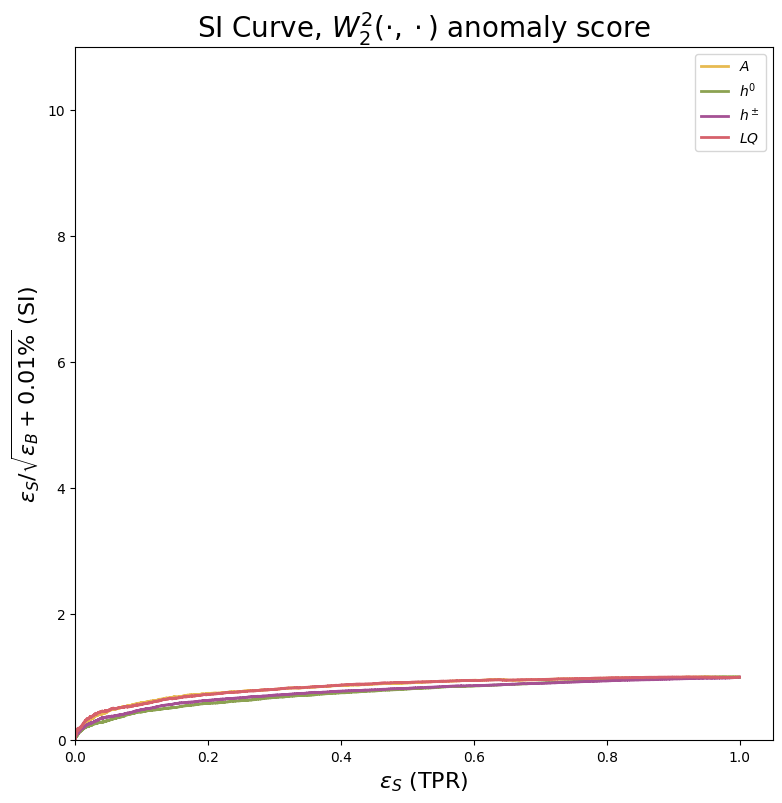

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 11)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0011 0.0011 0.0012]
[0.         0.01       0.11       0.07778175 0.08485281]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.6358680699999999
     $h^0$: 0.58589306
   $h^\pm$: 0.5882957499999999
      $LQ$: 0.63632278


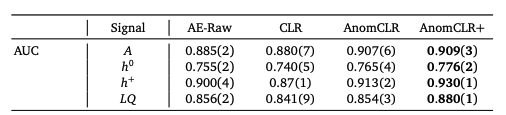

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1888, 2338, 2216, 1876]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 7.230657989877079 (TPR=0.3)
     $h^0$: 5.091649694501019 (TPR=0.2999)
   $h^\pm$: 5.668934240362812 (TPR=0.3001)
      $LQ$: 7.251631617113851 (TPR=0.2999)


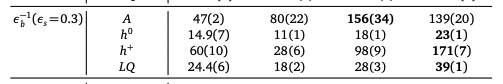

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.8064049958557056 (TPR=0.3)
     $h^0$: 0.6765426627750148 (TPR=0.2999)
   $h^\pm$: 0.7143213661681316 (TPR=0.3001)
      $LQ$: 0.8073036621362193 (TPR=0.2999)


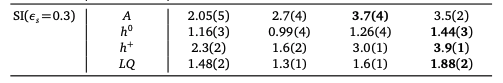

## div=KL; $\kappa=20$

In [ ]:
kwargs          = {}
kwargs['div']   = 'kl'
kwargs['reg_m'] = 20.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about ??s of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

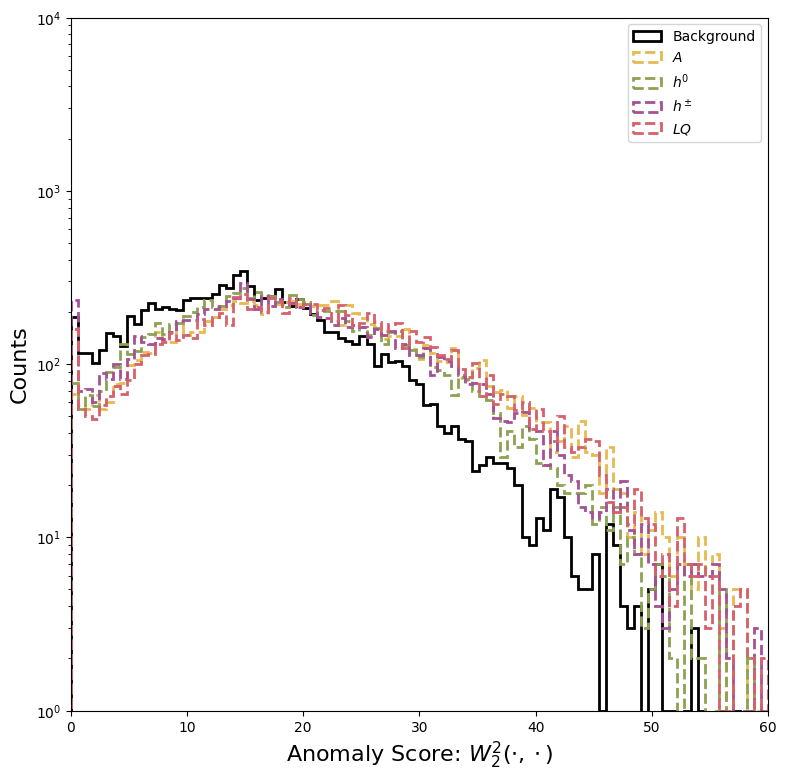

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 60)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

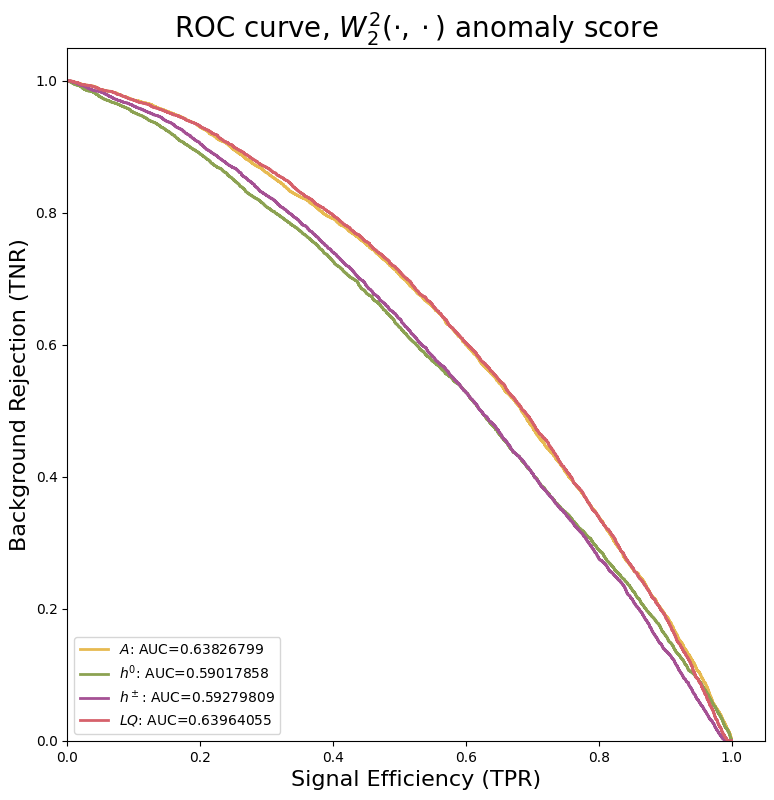

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

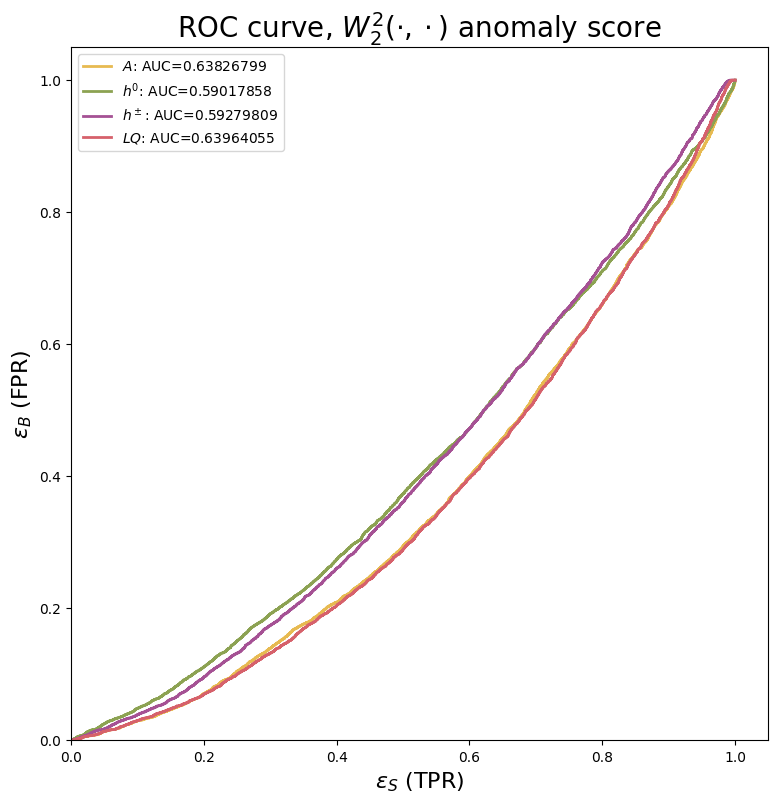

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

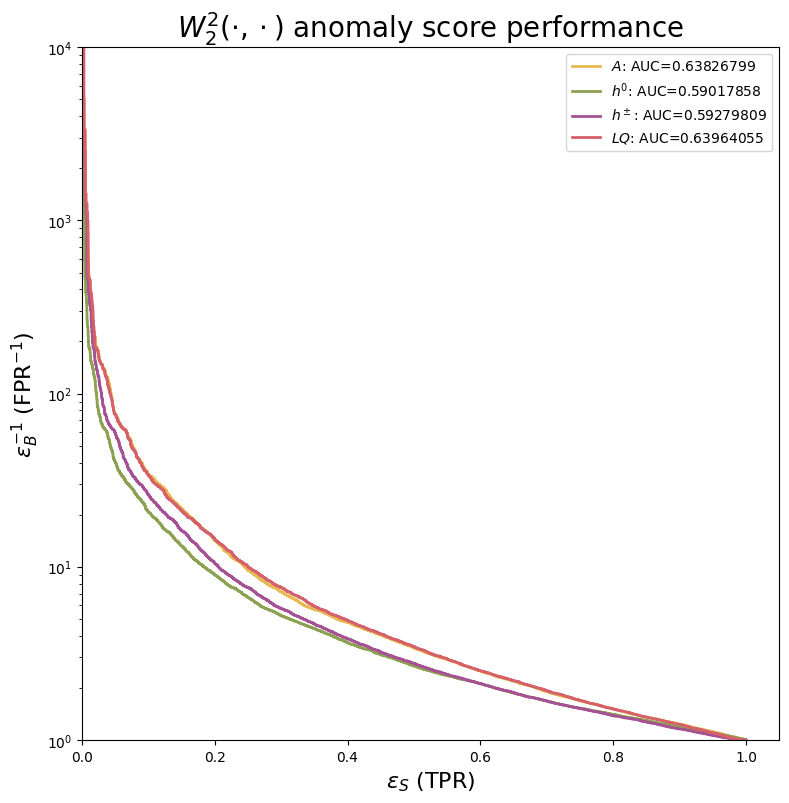

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

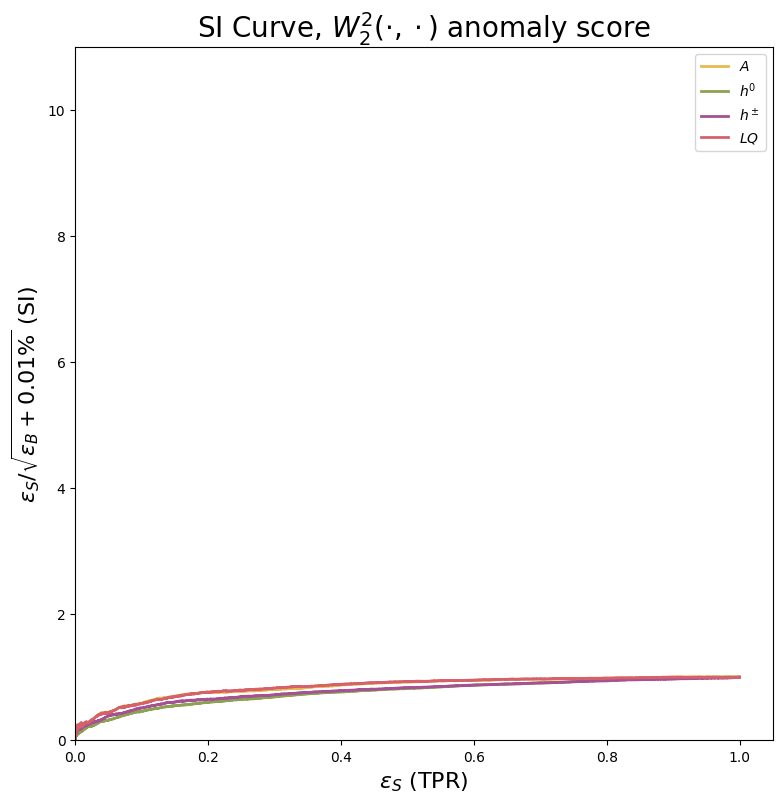

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 11)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0018 0.0018 0.0019]
[0.         0.01       0.18       0.12727922 0.13435029]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.63826799
     $h^0$: 0.59017858
   $h^\pm$: 0.59279809
      $LQ$: 0.63964055


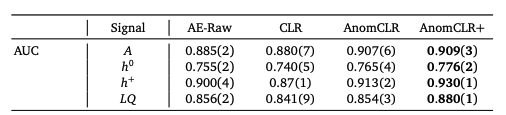

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1798, 2276, 2110, 1732]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 7.1890726096333575 (TPR=0.3004)
     $h^0$: 5.230125523012552 (TPR=0.2998)
   $h^\pm$: 5.7537399309551205 (TPR=0.3001)
      $LQ$: 7.587253414264036 (TPR=0.3003)


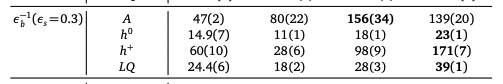

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.805156513663184 (TPR=0.3004)
     $h^0$: 0.6854474158957643 (TPR=0.2998)
   $h^\pm$: 0.719641507135608 (TPR=0.3001)
      $LQ$: 0.8268618112417989 (TPR=0.3003)


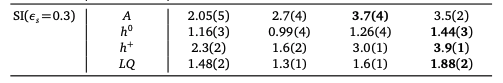

## div=KL; $\kappa=100$

In [ ]:
kwargs          = {}
kwargs['div']   = 'kl'
kwargs['reg_m'] = 100.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about ??s of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

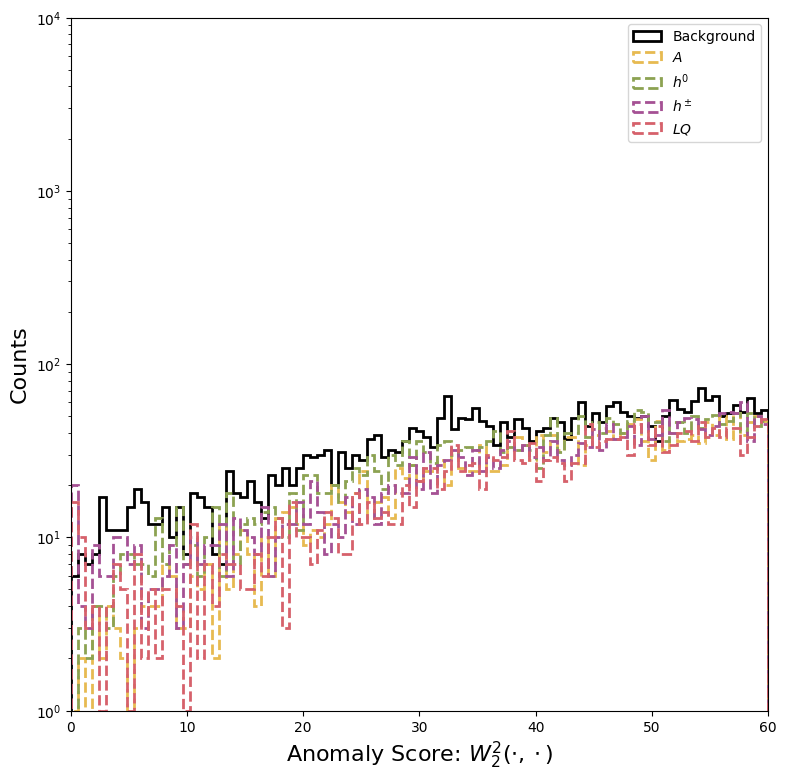

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 60)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

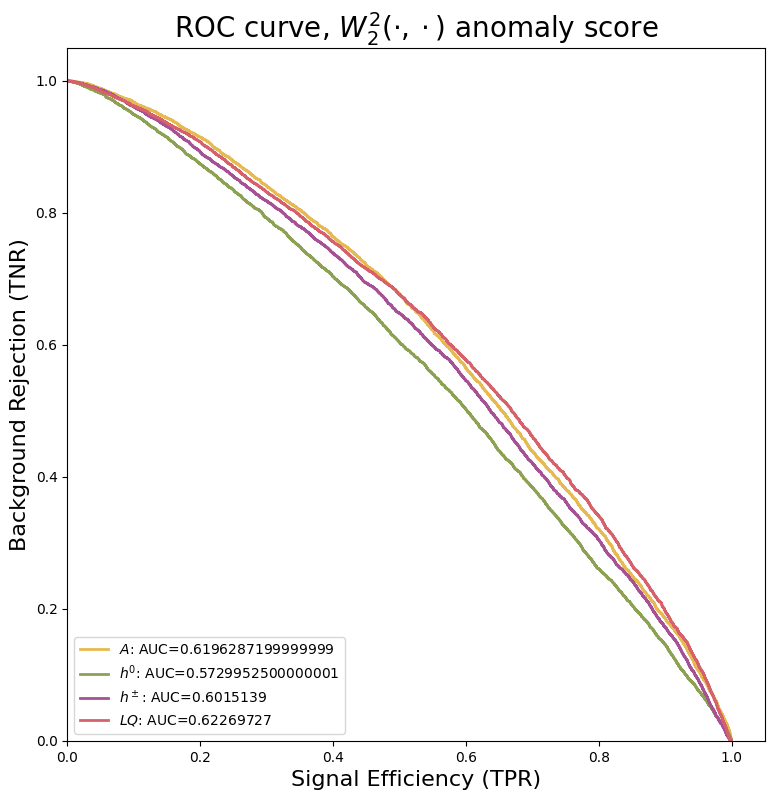

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

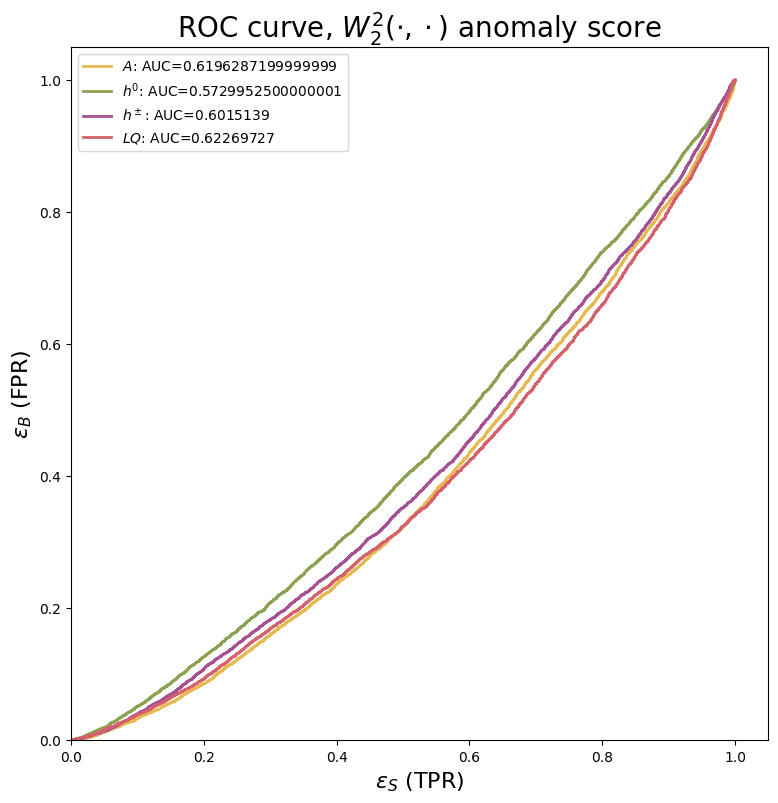

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

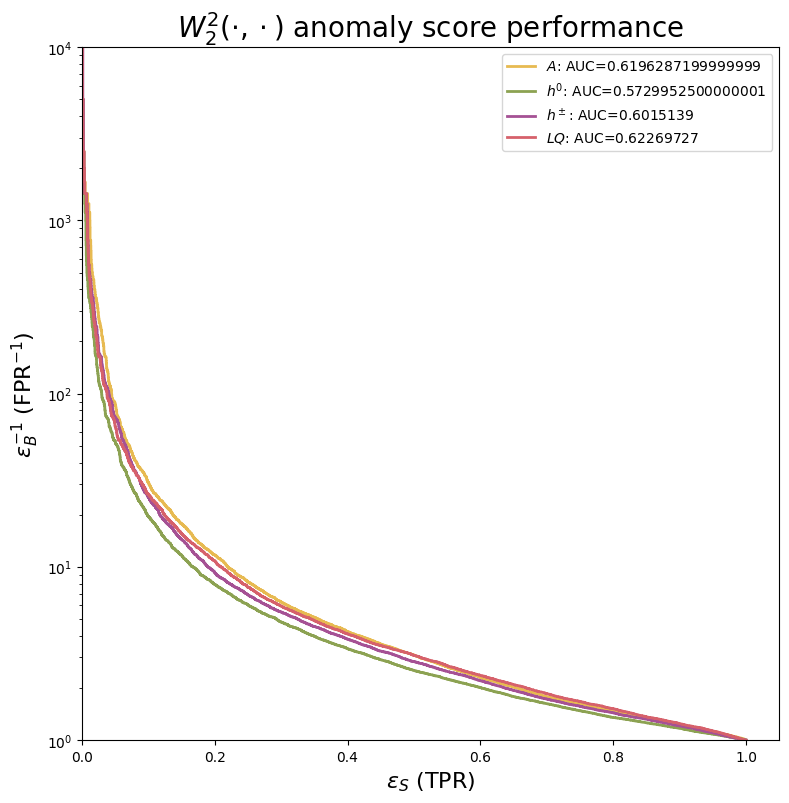

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

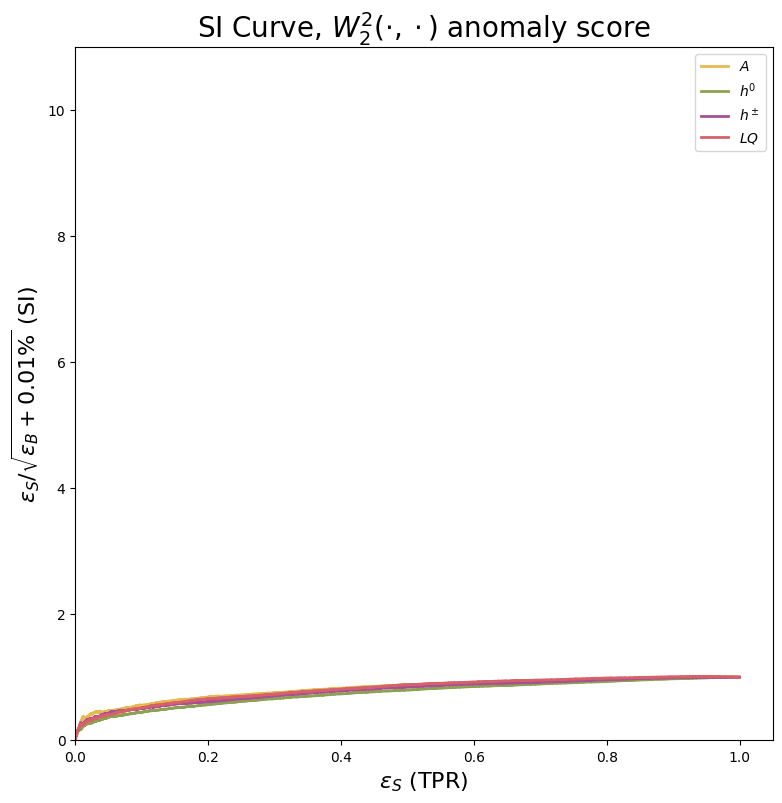

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 11)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0005 0.0005 0.0015]
[0.         0.01       0.05       0.03535534 0.10606602]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.6196287199999999
     $h^0$: 0.5729952500000001
   $h^\pm$: 0.6015139
      $LQ$: 0.62269727


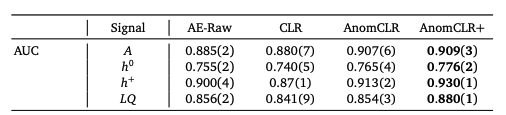

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2026, 2386, 2192, 2056]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 6.289308176100628 (TPR=0.3)
     $h^0$: 4.814636494944632 (TPR=0.2999)
   $h^\pm$: 5.491488193300384 (TPR=0.3001)
      $LQ$: 5.931198102016608 (TPR=0.3)


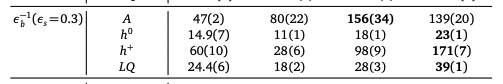

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.7521183158458503 (TPR=0.3)
     $h^0$: 0.6578906196112494 (TPR=0.2999)
   $h^\pm$: 0.7030590599035076 (TPR=0.3001)
      $LQ$: 0.7304049594989751 (TPR=0.3)


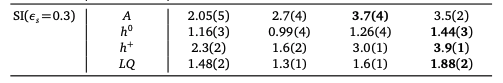